# ARIMA Forecasting of Tilapia Prices 

January 24, 2022

This IPython notebook details the step-by-step process of creating an ARIMA model for forecasting tilapia prices. <br><br>


Abstract: Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut scelerisque pretium consequat. Proin porttitor, odio id congue iaculis, nibh tortor sodales massa, at porttitor leo velit a turpis. Etiam ultrices lacus ac sem egestas facilisis. Vivamus ac luctus sapien. Sed sagittis ut lorem sit amet semper. Proin nec quam nec odio finibus placerat. Nam ultricies, diam eget consequat pulvinar, tellus nisi pharetra leo, id imperdiet nibh dui et neque. Ut sed enim at massa eleifend pretium. Praesent finibus hendrerit nulla nec scelerisque. Sed ut malesuada enim. <br><br>



Datasets from: https://www.da.gov.ph/price-monitoring/ <br>
Range of dataset used: **October 01, 2019 - August 31, 2021**

## Table of Contents
* <a href = '#Python-Modules'>Python Modules </a>
* <a href = '#Reading-the-parsed-data'>Reading the parsed data</a>
* <a href = '#Visualizing-the-data'>Visualizing the data</a>
* <a href = '#Developing-the-ARIMA-Model'>Developing the ARIMA Model</a>
* <a href = '#Testing-for-stationarity'>Testing for stationarity</a>
* <a href = '#Differencing-observations-by-an-order-of-one'>Differencing observations by an order of one</a>
* <a href = '#Determining-order-of-differencing'>Determining order of differencing</a>
* <a href = '#Determining-autoregression-and-moving-average-terms'>Determining autoregression and moving average terms</a>
* <a href = '#ARIMA(0,1,2)-fitting-and-summary'>ARIMA(0,1,2) fitting and summary</a>
* <a href = '#Forecast-fitting-and-visualization'>Forecast fitting and visualization</a>
* <a href = '#Diagnosing-ARIMA-model-residuals'>Diagnosing ARIMA model residuals</a>
* <a href = '#Evaluating-the-ARIMA-Model-with-RMSE'>Evaluating the ARIMA Model with RMSE</a>
* <a href = '#Discussion-of-the-results'>Discussion of the results</a>

### Python Modules

In [1]:
# Standard data processing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Statistical testing modules
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Additional math modules
from sklearn.metrics import mean_squared_error
from math import sqrt

# Remove unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Reading the parsed data

In [2]:
# Reading Csv
tilapia_df = pd.read_csv('C:\\Users\\infot\\Desktop\\data analytics\\data analytics scripts\\fixed csv\\tilapia.csv', parse_dates=[0], index_col=0)

# Pandas and Matplotlib plotting fix
pd.plotting.register_matplotlib_converters()

### Visualizing the data

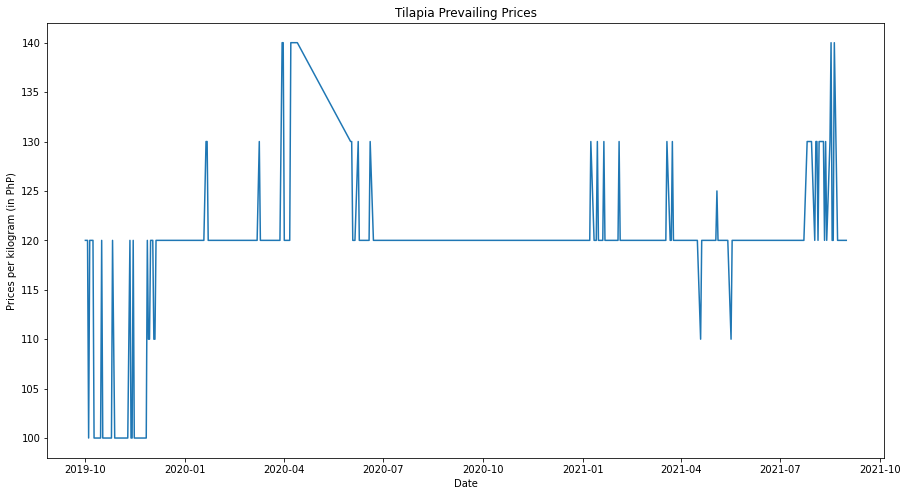

In [3]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Tilapia Prevailing Prices", xlabel = "Date", ylabel = "Prices per kilogram (in PhP)")
ax.plot(tilapia_df)
plt.show()

In [4]:
tilapia_df.head()

,prevailing
2019-10-01,120.0
2019-10-02,120.0
2019-10-03,120.0
2019-10-04,100.0
2019-10-05,120.0


In [5]:
tilapia_df.tail()

,prevailing
2021-08-26,120.0
2021-08-27,120.0
2021-08-28,120.0
2021-08-30,120.0
2021-08-31,120.0


## Developing the ARIMA Model
The ARIMA model is a generalized autoregression and moving average model used in time-series analysis. The model requires the necessity the analyze for the number of autoregression terms, nonseasonal differences for stationarity, and moving average terms. 

#### Construction of an ARIMA Model
1. Stationarizing the series by differencing
2. Analyzing the autocorrelations and partial autocorrelations to determine the number of autoregression and moving average terms 
3.  Fitting the model and diagnosing residuals 
4.  Adjusting the number of autogression and moving average terms if necessary
<br>


For this model, it is necessary to determine if the time-series inputs are stationary. A stationary time-series is one whose process does not depend on time. Specifically, having the properties of constant mean and constant variance as the time-series goes on.

### Testing for stationarity
For this time-series, the researcher will use the Augmented Dicky-Fuller test for stationarity. The Augmented Dicky-Fuller test is a common unit root test for determining stationarity that includes a high order autoregressive process compared to its counterpart, the Dicky-Fuller test. Both these tests assume are used to determine if a time-series has a unit root, a characteristic of time-series to be non-stationary <br>

#### The usual hypotheses for this test are:
Ho: The time-series has a unit root. It is non-stationary <br>
H1: The time-series is stationary <br>

The result of this test reveals that time-series is stationary. Therefore, it may or may not be necessary to difference the series.

In [6]:
# Defining ADF function
def adfuller_test(dataframe):
    result=adfuller(dataframe)
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho). Therefore, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis. The time series has a unit root, indicating it is non-stationary")

In [7]:
# Calling the ADF function
adfuller_test(tilapia_df['prevailing'])

ADF Test Statistic : -3.0916587956078185
p-value : 0.02717666483247284
Number of Lags Used : 11
Number of Observations Used : 589
Strong evidence against the null hypothesis(Ho). Therefore, reject the null hypothesis. Data has no unit root and is stationary


### Differencing observations by an order of one

In [8]:
tilapia_stationary = tilapia_df.diff().dropna()

<AxesSubplot:>

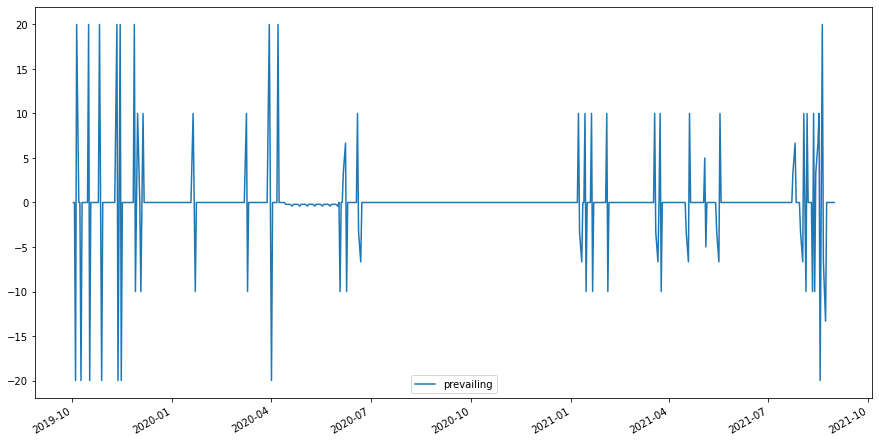

In [9]:
tilapia_stationary.plot(figsize=(15, 8))

In [10]:
tilapia_stationary.head()

,prevailing
2019-10-02,0.0
2019-10-03,0.0
2019-10-04,-20.0
2019-10-05,20.0
2019-10-07,0.0


### Determining order of differencing
A systematic way of determining the order of differncing for an an ARIMA model is by looking at the autocorrelation and partial autocorrelation plots of the time-series. In general, there are a few rules that can be used for identifying the proper differencing model using the ACF and PACF plots:
* If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing
* If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.
* The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.
* A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).
* A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

The result of the test reveals that time-series is stationary. The time-series presumably does not need anymore differencing as it is stationary. However, after looking at the number of positive correlations, differencing is necessary as it lacks a tendency to return to its mean value.

### Determining autoregression and moving average terms
A systematic way of determining the AR and MA terms of an ARIMA model is by looking at the autocorrelation and partial autocorrelation plots of the time-series. In general, there are a few rules that can be used for identifying the proper ARIMA model using the ACF and PACF plots:
* If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.
* If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.
* It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.
* If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.
* If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.
* If the long-term forecasts appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

For this time-series, the lag-1 correlation is negative and the ACF displays a sharper cutoff. The ARIMA model can include MA(2) terms at the ACF cuts off at lag-2.

#### Plotting autocorrelation function of observations

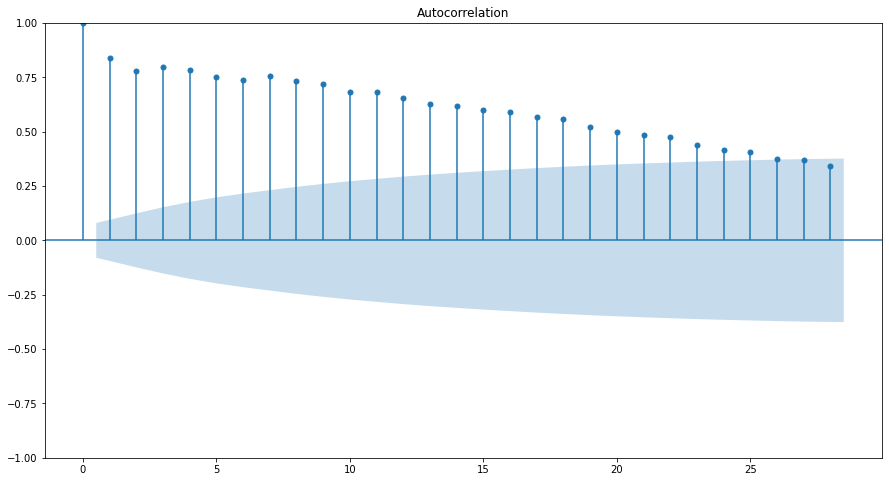

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Autocorrelation")
plot_acf(tilapia_df, ax=ax)
plt.show()

#### Plotting partial autocorrelation function of observations

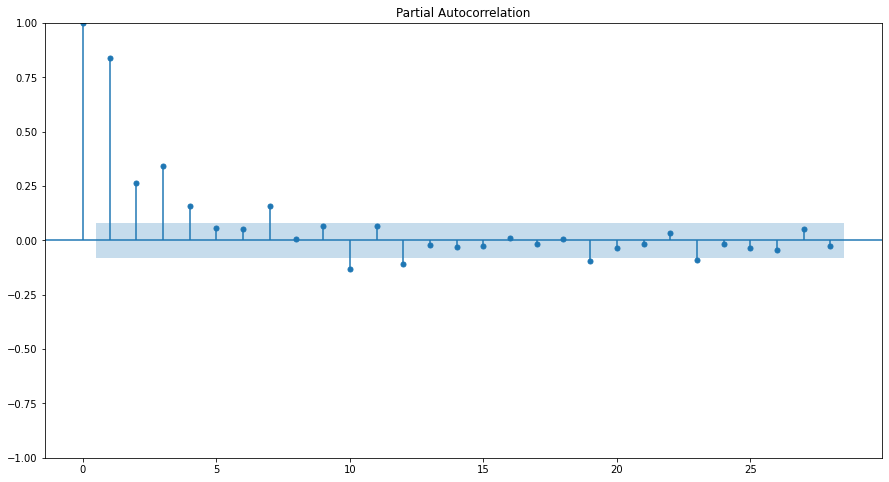

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Partial Autocorrelation")
plot_pacf(tilapia_df, ax=ax)
plt.show()

#### Plotting autocorrelation function of differenced observations

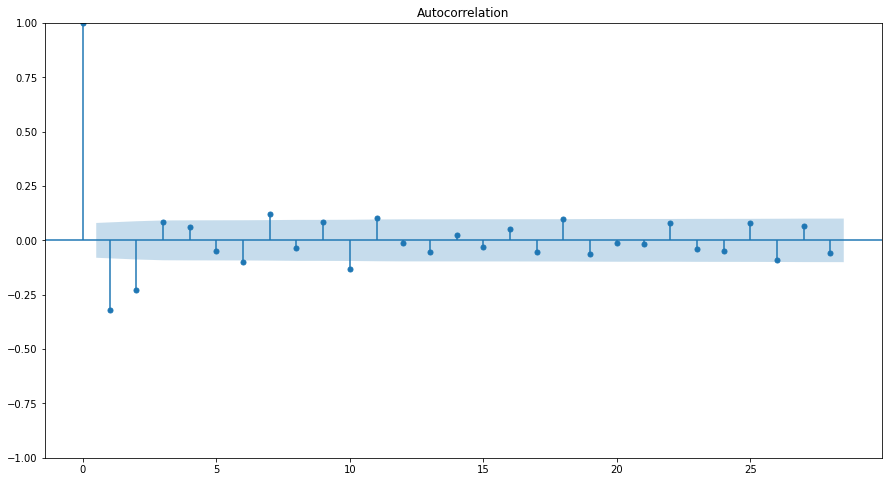

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Autocorrelation")
plot_acf(tilapia_stationary, ax=ax)
plt.show()

#### Plotting partial autocorrelation function of differenced observations

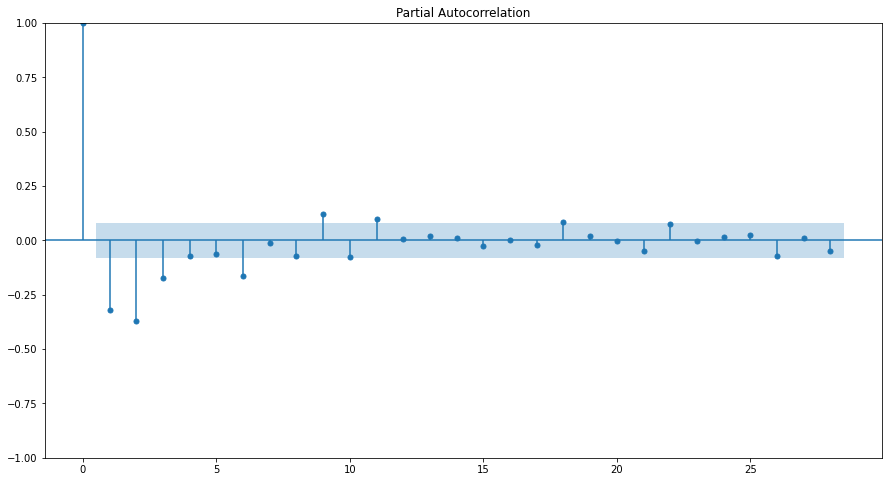

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Partial Autocorrelation")
plot_pacf(tilapia_stationary, ax=ax)
plt.show()

### ARIMA(0,1,2) fitting and summary
The model is determined to have one order of differencing and two moving average terms. The result summary shows that the moving average terms are significant and the model does not show a lack of good fit--in other words, the model is fine

In [15]:
model = ARIMA(tilapia_df, order=(0,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             prevailing   No. Observations:                  601
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1625.115
Date:                Sun, 30 Jan 2022   AIC                           3256.230
Time:                        19:25:45   BIC                           3269.421
Sample:                             0   HQIC                          3261.365
                                - 601                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5152      0.021    -24.460      0.000      -0.556      -0.474
ma.L2         -0.1754      0.026     -6.868      0.000      -0.225      -0.125
sigma2        13.1740      0.307     42.883      0.000      12.572      13.776
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              3835.77
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast fitting and visualization
The forecast is dated from the last period of the actual observation to today (January 24, 2022)

In [16]:
# Training data fit
tilapia_df['training'] = model_fit.predict(start=datetime(2019,10,2), end=datetime(2021,8,31))
tilapia_df.at['2019-10-01', 'training'] = tilapia_df['prevailing'].mean()

In [17]:
# Setting frequency offset
week = "Mon Tue Wed Thu Fri Sat"
nosun = pd.offsets.CustomBusinessDay(weekmask=week)

# Make daterange of forecast dates
idx = pd.date_range(start = '2021-08-31', end = '2022-01-24', freq = nosun)

# Fit model predictions
future = model_fit.get_forecast(126)

# Format as dataframe
future_df = pd.DataFrame(future.predicted_mean)
future_df['date'] = idx
future_df = future_df.set_index('date')
future_df.columns = ['forecast']

In [18]:
conf_df = pd.DataFrame(future.conf_int(alpha=0.05))
conf_df['date'] = idx
conf_df = conf_df.set_index('date')
conf_df.columns = ['lower bound', 'upper bound']

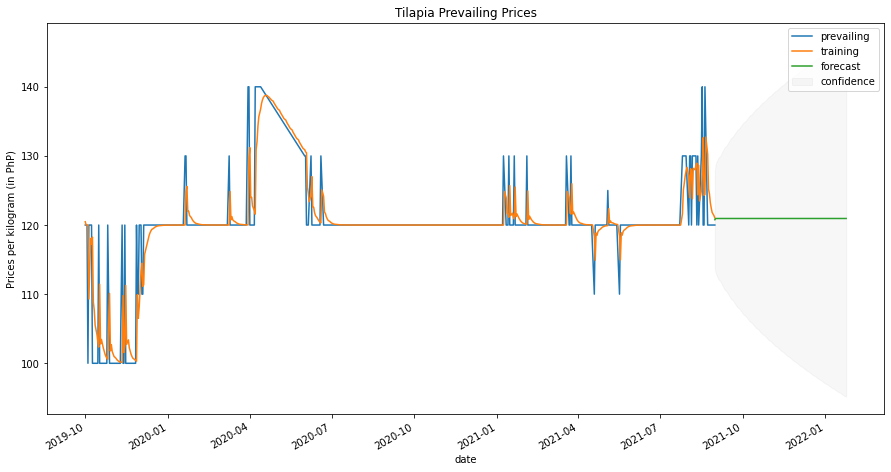

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Tilapia Prevailing Prices", xlabel = "Date", ylabel = "Prices per kilogram (in PhP)")
tilapia_df.plot(ax=ax)
future_df.plot(ax=ax)
plt.fill_between(idx, conf_df['lower bound'], conf_df['upper bound'], color="dimgray",alpha=0.05, label="confidence")
plt.legend(loc='best')
plt.show()

In [20]:
future_df.head()

,forecast
date,
2021-08-31,120.768267
2021-09-01,120.948066
2021-09-02,120.948066
2021-09-03,120.948066
2021-09-04,120.948066


In [21]:
future_df.tail()

,forecast
date,
2022-01-19,120.948066
2022-01-20,120.948066
2022-01-21,120.948066
2022-01-22,120.948066
2022-01-24,120.948066


### Diagnosing ARIMA model residuals
The residuals show non-significant autocorrelations, normal distributions, and a mean closer to zero indicating good fit

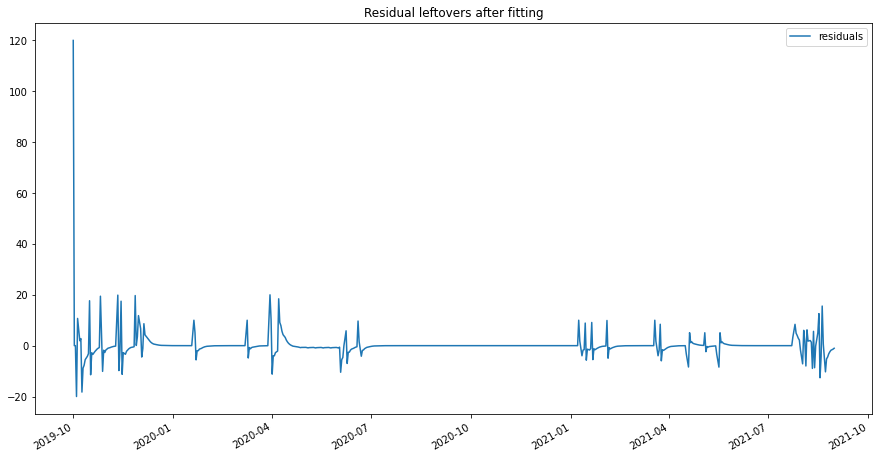

In [22]:
residuals = pd.DataFrame(model_fit.resid)
residuals.columns = ['residuals']
residuals.plot(figsize=(15, 8), title="Residual leftovers after fitting")
plt.show()

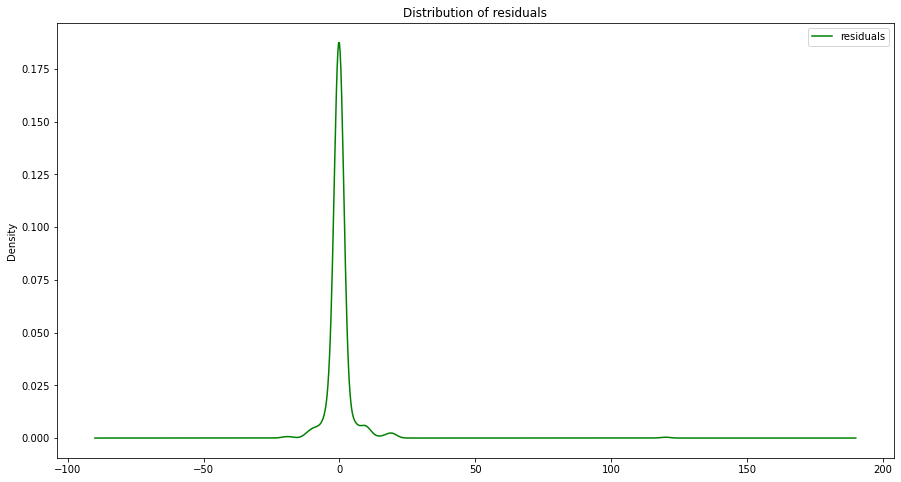

In [23]:
residuals.plot.kde(figsize=(15, 8), color="green", title="Distribution of residuals")
plt.show()

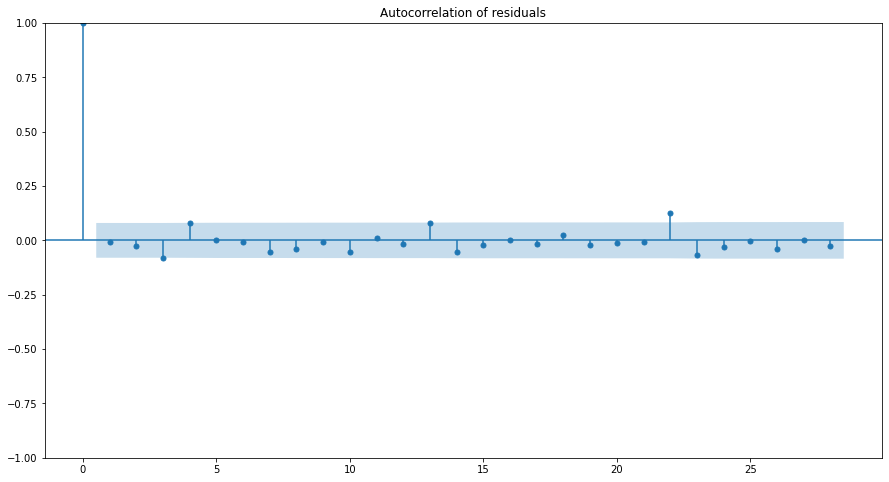

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
#ax.set(title = "Autocorrelation of residuals")
plot_acf(residuals, title = "Autocorrelation of residuals", ax=ax)
plt.show()

In [25]:
print(residuals.describe())

        residuals
count  601.000000
mean     0.209979
std      6.098019
min    -19.999702
25%     -0.535567
50%     -0.000028
75%      0.000030
max    120.000000


### Evaluating the ARIMA Model with RMSE
The root mean squared error shows 3.6 which is minimal enough to prove for accuracy

In [26]:
mse = mean_squared_error(tilapia_df['prevailing'], tilapia_df['training'])
rmse = sqrt(mse)
print('RMSE value: %f' % rmse)

RMSE value: 3.634332


### Discussion of the results
* The autocorrelation of the residuals show almost no significant values. 
* The RMSE shows minimal error
* The Ljung-Box test accepts the null hypothesis indiciating good fit
* The other parts of the summary indicates that the moving average term is significant 

This result implies that ARIMA(0,1,2) is a good fit for forecasting fish prices during the even accounting for the pandemic lockdowns.